In [25]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma

In [26]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [27]:
import deeptime
deeptime.__version__

'0.4.4'

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda:2")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

device = torch.device("cpu")
print(f"Using device {device}")

Using device cpu


In [29]:
class Trimer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
        
    def state_to_features(self):
        if self._state == "CCC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CCO":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "COC":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OCC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "COO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OCO":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OOC":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6, 0.9, 0.1, 0.6])  
        elif self._state == "OOO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6, 0.1, 0.9, 0.6])

    def old_state_to_features(self):
        if self._state == "CCC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CCO":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "COC":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OCC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "COO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OCO":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OOC":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6, 0.9, 0.1, 0.6])  
        elif self._state == "OOO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6, 0.1, 0.9, 0.6])

    def run(self, step):
        self._trajectory = np.zeros([step, 9])
        self._trajectory_state_sub = np.zeros([step, 3])
        
        self.feat = np.random.normal(0, 1, 30)


        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        self._trajectory_state_sub[0] = self.state_dic[self._state]

        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()
            self._trajectory_state_sub[i] = self.state_dic[self._state]

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
        noise = np.random.normal(0, .01, self._trajectory_state_sub.shape)
#        self._trajectory_state_sub = self._trajectory_state_sub + noise


        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def state_trajectory(self):
        return self._trajectory_state_sub

    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CCC",
              "CCO", "COC", "OCC",
              "COO", "OCO", "OOC",
              "OOO"]
    
    single_states = ["C", "O"]

    state_dic = {
                'CCC': np.asarray([0, 0, 0]),
                'CCO': np.asarray([0, 0, 1]),
                'COC': np.asarray([0, 1, 0]),
                'OCC': np.asarray([1, 0, 0]),    
                'COO': np.asarray([0, 1, 1]),
                'OOC': np.asarray([1, 1, 0]),
                'OCO': np.asarray([1, 0, 1]),
                'OOO': np.asarray([1, 1, 1])
            }

    # Possible sequences of events
    transitionName = [["_".join([st1, st2]) for st1, st2 in itertools.product(["CCC"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["CCO"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["COC"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["OCC"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["COO"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["OCO"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["OOC"], states)],
                      ["_".join([st1, st2]) for st1, st2 in itertools.product(["OOO"], states)]]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.5, 0.1, 0.1, 0.1, 0.065, 0.065, 0.065, 0.005],
                        [0.2, 0.2, 0.0, 0.0, 0.3, 0.3, 0.0, 0.0],
                        [0.2, 0.0, 0.2, 0.0, 0.3, 0.0, 0.3, 0.0],
                        [0.2, 0.0, 0.0, 0.2, 0.0, 0.3, 0.3, 0.0],
                        [0.0, 0.05, 0.05, 0.0, 0.3, 0.0, 0.0, 0.6],
                        [0.0, 0.05, 0.0, 0.05, 0.0, 0.3, 0.0, 0.6],
                        [0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.3, 0.6],
                        [0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.7]]

In [40]:
glic_trimer = Trimer(0)

In [41]:
glic_trimer.run(500)

In [42]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [43]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_trimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 3, data)

In [44]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= tica.transform(dataset)
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

In [57]:
covariances = tica_model_tica.cov
subset_rank = covariances.cov_00.shape[0] // 3
cov_00_blocks = []
cov_0t_blocks = []
cov_tt_blocks = []
for i in range(3):
    cov_00_blocks.append(covariances.cov_00[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
    cov_0t_blocks.append(covariances.cov_0t[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
    cov_tt_blocks.append(covariances.cov_tt[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
                        
#        cov_00 = covariances.cov_00[:subset_rank, :subset_rank]
#        cov_0t = covariances.cov_0t[:subset_rank, :subset_rank]
#        cov_tt = covariances.cov_tt[:subset_rank, :subset_rank]
cov_00 = np.sum(cov_00_blocks, axis=0)
cov_0t = np.sum(cov_0t_blocks, axis=0)
cov_tt = np.sum(cov_tt_blocks, axis=0)

In [53]:
cov_00_blocks

[array([[ 1.07699521e-01, -1.07487540e-01, -5.83713064e-05],
        [-1.07487540e-01,  1.07469421e-01,  6.22520469e-05],
        [-5.83713064e-05,  6.22520469e-05,  9.80741778e-05]]),
 array([[ 1.26784263e-02, -1.26632928e-02, -6.31800306e-05],
        [-1.25158023e-02,  1.24911955e-02,  6.09258861e-05],
        [-7.39695771e-05,  7.65868731e-05,  3.35230971e-07]]),
 array([[ 1.26784263e-02, -1.25158023e-02, -7.39695771e-05],
        [-1.26632928e-02,  1.24911955e-02,  7.65868731e-05],
        [-6.31800306e-05,  6.09258861e-05,  3.35230971e-07]])]

<AxesSubplot: >

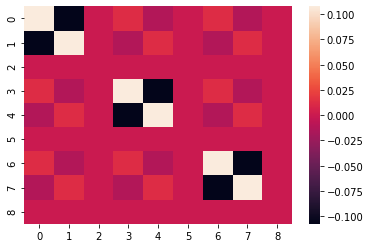

In [45]:
sns.heatmap(tica_model_tica.cov_00)

In [46]:
from deeptime.decomposition import TICA

tica_aug = TICA(var_cutoff=None, lagtime=5)

tica_aug.fit(glic_trimer.trajectory)

tica_output= tica_aug.transform(glic_trimer.trajectory)
tica_concatenated= np.concatenate(tica_output)

tica_aug_model_tica = tica_aug.fetch_model()

<AxesSubplot: >

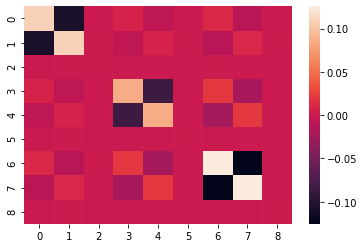

In [47]:
sns.heatmap(tica_aug_model_tica.cov_00)

In [54]:
covariances = tica_aug_model_tica.cov
subset_rank = covariances.cov_00.shape[0] // 3
cov_00_blocks = []
cov_0t_blocks = []
cov_tt_blocks = []
for i in range(3):
    cov_00_blocks.append(covariances.cov_00[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
    cov_0t_blocks.append(covariances.cov_0t[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
    cov_tt_blocks.append(covariances.cov_tt[:subset_rank,
                            i * subset_rank:(i + 1) * subset_rank])
                        
#        cov_00 = covariances.cov_00[:subset_rank, :subset_rank]
#        cov_0t = covariances.cov_0t[:subset_rank, :subset_rank]
#        cov_tt = covariances.cov_tt[:subset_rank, :subset_rank]
cov_00 = np.sum(cov_00_blocks, axis=0)
cov_0t = np.sum(cov_0t_blocks, axis=0)
cov_tt = np.sum(cov_tt_blocks, axis=0)

In [56]:
cov_00

array([[ 1.27275021e-01, -1.26470503e-01, -6.61600534e-04],
       [-1.27012578e-01,  1.26370164e-01,  6.70851305e-04],
       [-3.22599535e-05,  3.05775022e-05,  1.04511464e-04]])

In [58]:
cov_00

array([[ 1.33056373e-01, -1.32666635e-01, -1.95520914e-04],
       [-1.32666635e-01,  1.32451812e-01,  1.99764806e-04],
       [-1.95520914e-04,  1.99764806e-04,  9.87446398e-05]])

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


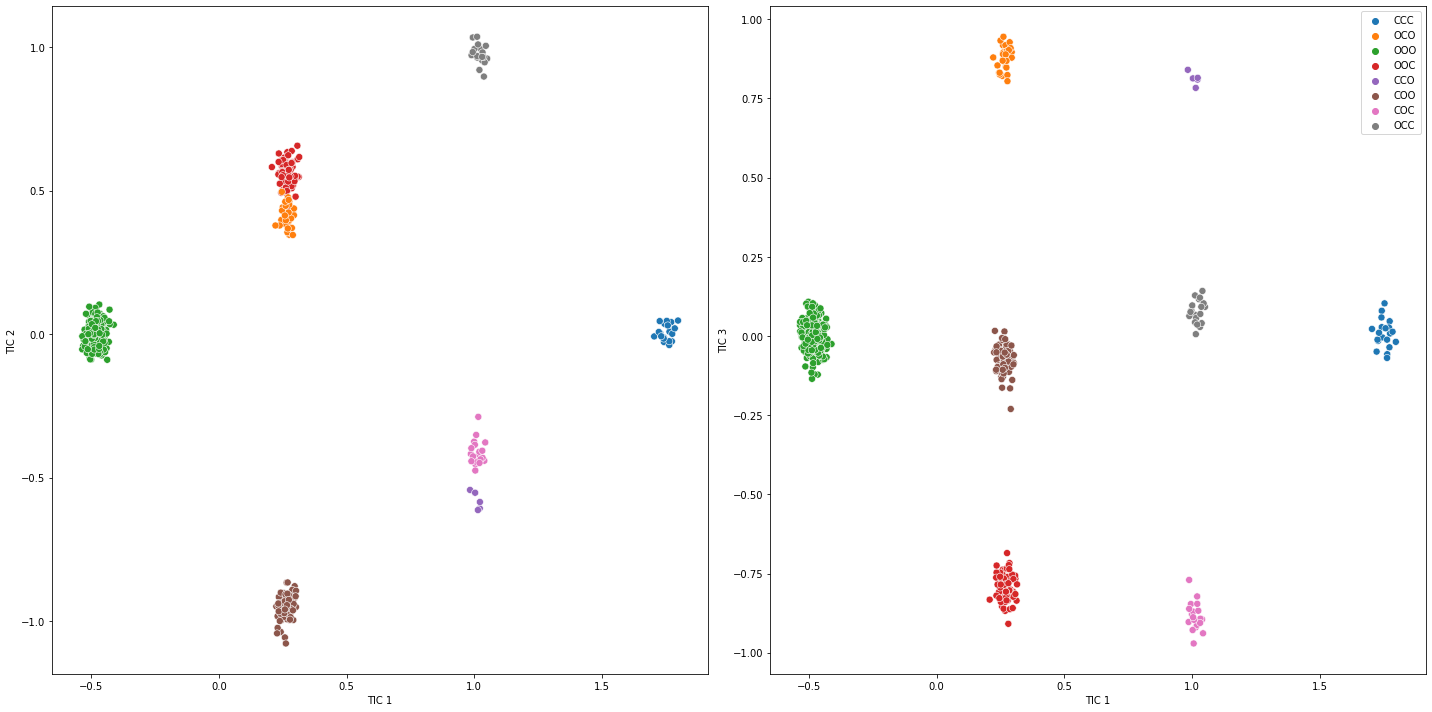

In [48]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(
            feature_transformed[:, 0],
            feature_transformed[:, 1],
            hue=glic_trimer.trajectory_states,
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            feature_transformed[:, 0],
            feature_transformed[:, 2],
            hue=glic_trimer.trajectory_states,
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")
plt.legend(loc='upper right')
plt.tight_layout()

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Timescale index')

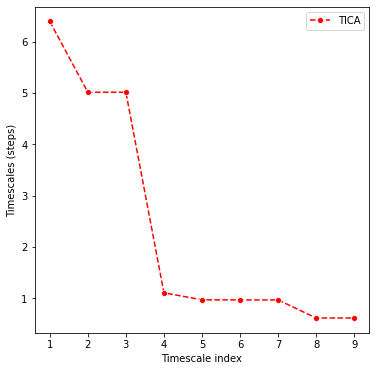

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1), tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='TICA')
ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [11]:
from msm_a7_nachrs.tica.sym_tica import SymTICA

symtica = SymTICA(symmetry_fold=3, var_cutoff=0.8, lagtime=5)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
#symtica_output= symtica.transform([glic_trimer.trajectory.reshape(glic_trimer.trajectory.shape[0], 3, -1).mean(axis=2)])
symtica_concatenated= np.concatenate(symtica_output)

symmetry_fold 3


In [15]:
symtica_model_tica = symtica.fetch_model()

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'TIC 1')

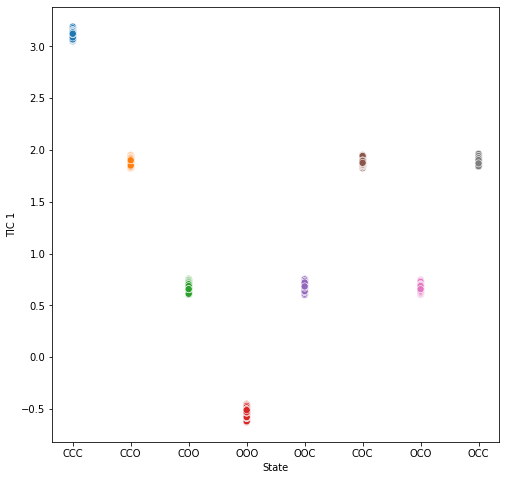

In [16]:
feature = dataset.trajectories[0]
feature_transformed = symtica.transform(feature)
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(glic_trimer.trajectory_states, feature_transformed[:, 0], hue=glic_trimer.trajectory_states, s=50, alpha=1, ax=ax,
                legend=False)
ax.set_xlabel("State")
ax.set_ylabel("TIC 1")

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Timescale index')

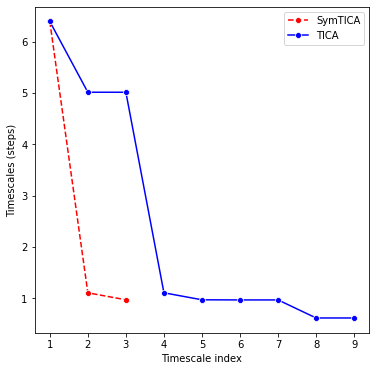

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1), symtica_model_tica.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='SymTICA')
sns.lineplot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1), tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='-', color='blue', label='TICA')

ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [22]:
data_contat = np.concatenate(data)

In [23]:
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [24]:
from torch.utils.data import DataLoader

#loader_train = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
loader_train = DataLoader(train_data, batch_size=20000, shuffle=True)

loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [13]:
from deeptime.decomposition.deep import vampnet_loss, vamp_score

(array([  810.,   675.,  5400.,     0., 31350.,  5230.,     0.,  5120.,
          680.,   735.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

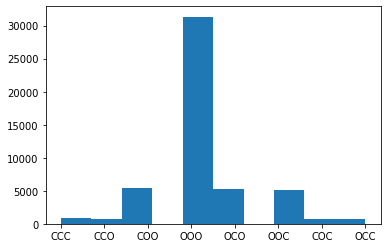

In [14]:
plt.hist(glic_trimer.trajectory_states)

In [15]:
class MultimerNet(nn.Module):
    def __init__(self, data_shape, multimer, n_states):
        super().__init__()
        self.data_shape = data_shape
        self.multimer = multimer
        self.n_states = n_states
        
        self.n_feat_per_sub = self.data_shape // self.multimer


        self.batchnorm1d = nn.BatchNorm1d(self.n_feat_per_sub)
        

        # Fully connected layers into monomer part
        self.fc1 = nn.Linear(self.n_feat_per_sub, 20)
        self.elu1 = nn.ELU()
        
        self.fc2 = nn.Linear(20, 20)
        self.elu2 = nn.ELU()

        self.fc3 = nn.Linear(20, 20)
        self.elu3 = nn.ELU()

        self.fc4 = nn.Linear(20, 20)
        self.elu4 = nn.ELU()
        
        self.fc5 = nn.Linear(20, self.n_states)
        self.softmax = nn.Softmax(dim=1)
        
        self.tanh1 = nn.Tanh()


        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
#          self.dropout1 = nn.Dropout2d(0.25)
#          self.dropout2 = nn.Dropout2d(0.5)

    # x represents our data
    def forward(self, x):
 #       x = self.batchnorm1d(x)
        
        batch_size = x.shape[0]
        
        n_feat_per_sub = int(self.data_shape / self.multimer)
        x_splits = x.reshape(batch_size, self.multimer, self.n_feat_per_sub)
        output = []
        
        x_stack = torch.permute(x_splits, (1,0,2)).reshape(batch_size * self.multimer, self.n_feat_per_sub)
        x_stack = self.batchnorm1d(x_stack)

        x_stack = self.fc1(x_stack)
        x_stack = self.elu1(x_stack)
        x_stack = self.fc2(x_stack)
        x_stack = self.elu2(x_stack)
        x_stack = self.fc3(x_stack)
        x_stack = self.elu3(x_stack)
        x_stack = self.fc4(x_stack)
        x_stack = self.elu4(x_stack)
        x_stack = self.fc5(x_stack)
        x_stack = self.softmax(x_stack) 
        
        x_splits = x_stack.reshape(self.multimer, batch_size, self.n_states).permute(1,0,2).reshape(batch_size, self.n_states * self.multimer)
        return x_splits
    

        
    
        
        
trimer_twostate_lobe = MultimerNet(data_shape=data[0].shape[1], multimer=3, n_states=2)
trimer_twostate_lobe = trimer_twostate_lobe.to(device=device)

In [16]:
from deeptime.decomposition.deep import VAMPNet
from copy import deepcopy

from typing import Optional, Union, Callable, Tuple
from deeptime.decomposition.deep import vampnet_loss, vamp_score
from deeptime.util.torch import disable_TF32, map_data
from msm_a7_nachrs.vampnet.vampnet import VAMPNet_Multimer_NOSYM

In [17]:
vampnets = [VAMPNet_Multimer_NOSYM(
                             n_states=2,
                             multimer=3,
                             lobe=deepcopy(trimer_twostate_lobe).to(device=device),
                             score_method='VAMPE',
                             learning_rate=5e-3,
                             device=device) for i in range(4)]

In [18]:
from tqdm.notebook import tqdm  # progress bar
models = [vampnet.fit(loader_train, n_epochs=n_epoch,
                    validation_loader=loader_val, progress=tqdm).fetch_model() for vampnet, n_epoch in zip(vampnets, [10, 20, 30, 40])]

VAMPNet epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torch/functional.py:1580: UserWarning: torch.chain_matmul is deprecated and will be removed in a future PyTorch release. Use torch.linalg.multi_dot instead, which accepts a list of two or more tensors rather than multiple parameters. (Triggered internally at ../aten/src/ATen/native/LinearAlgebra.cpp:967.)
  return _VF.chain_matmul(matrices)  # type: ignore[attr-defined]


VAMPNet epoch:   0%|          | 0/20 [00:00<?, ?it/s]

VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]

VAMPNet epoch:   0%|          | 0/40 [00:00<?, ?it/s]

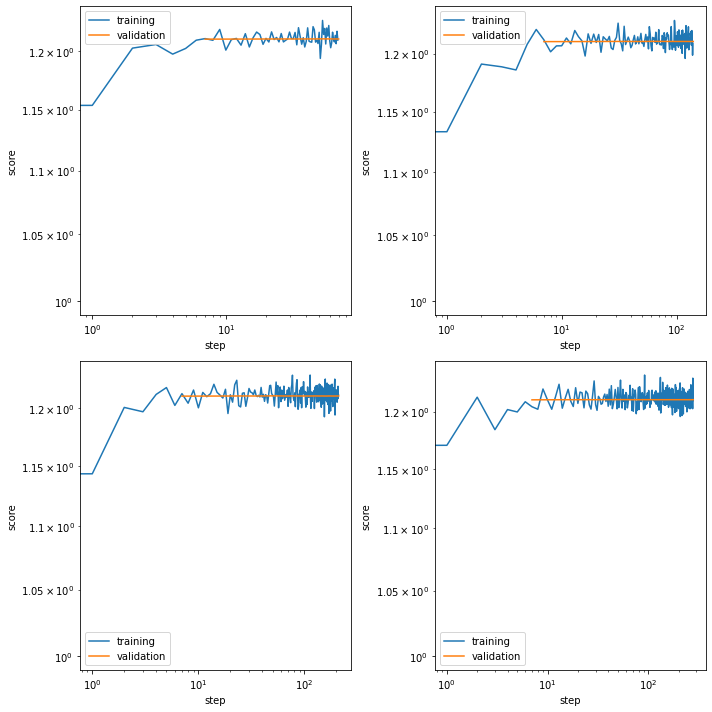

In [19]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
for vampnet, ax in zip(vampnets, axes.flatten()):
    ax.loglog(*vampnet.train_scores.T, label='training')
    ax.loglog(*vampnet.validation_scores.T, label='validation')
    ax.set_xlabel('step')
    ax.set_ylabel('score')
    ax.legend()
plt.tight_layout()

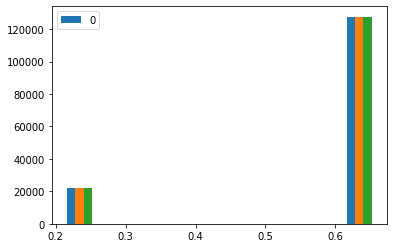

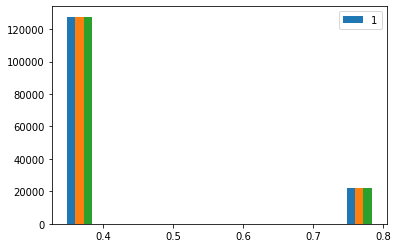

Subunit 1 ,State 1: [0.21185532212257385, 0.6564170122146606]
Subunit 1 ,State 2: [0.34358298778533936, 0.7881446480751038]
Subunit 2 ,State 1: [0.21185532212257385, 0.6564170122146606]
Subunit 2 ,State 2: [0.34358298778533936, 0.7881446480751038]
Subunit 3 ,State 1: [0.21185532212257385, 0.6564170122146606]
Subunit 3 ,State 2: [0.34358298778533936, 0.7881446480751038]



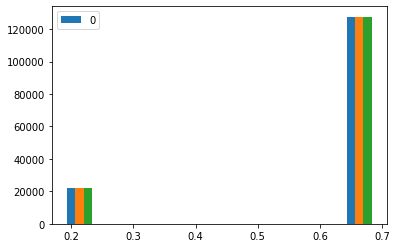

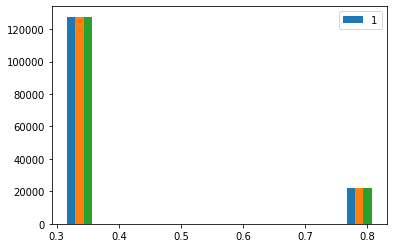

Subunit 1 ,State 1: [0.18842723965644836, 0.6882238984107971]
Subunit 1 ,State 2: [0.31177613139152527, 0.8115727305412292]
Subunit 2 ,State 1: [0.18842723965644836, 0.6882238984107971]
Subunit 2 ,State 2: [0.31177613139152527, 0.8115727305412292]
Subunit 3 ,State 1: [0.18842723965644836, 0.6882238984107971]
Subunit 3 ,State 2: [0.31177613139152527, 0.8115727305412292]



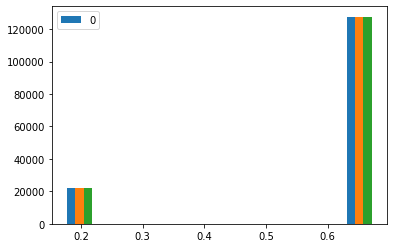

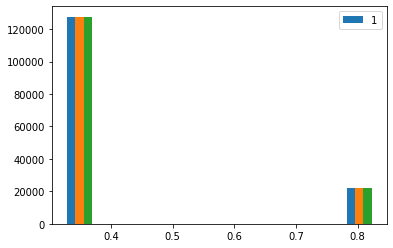

Subunit 1 ,State 1: [0.17248904705047607, 0.6764093637466431]
Subunit 1 ,State 2: [0.32359057664871216, 0.8275108933448792]
Subunit 2 ,State 1: [0.17248904705047607, 0.6764093637466431]
Subunit 2 ,State 2: [0.32359057664871216, 0.8275108933448792]
Subunit 3 ,State 1: [0.17248904705047607, 0.6764093637466431]
Subunit 3 ,State 2: [0.32359057664871216, 0.8275108933448792]



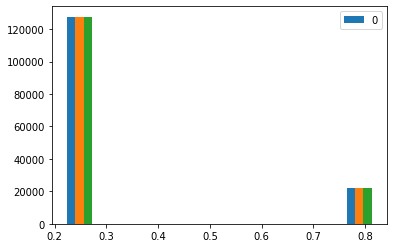

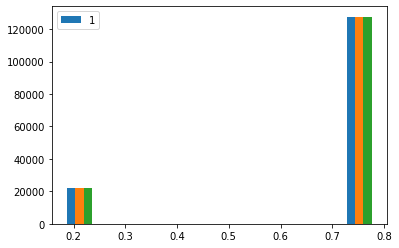

Subunit 1 ,State 1: [0.21802747249603271, 0.8184952735900879]
Subunit 1 ,State 2: [0.1815047413110733, 0.7819725275039673]
Subunit 2 ,State 1: [0.21802747249603271, 0.8184952735900879]
Subunit 2 ,State 2: [0.1815047413110733, 0.7819725275039673]
Subunit 3 ,State 1: [0.21802747249603271, 0.8184952735900879]
Subunit 3 ,State 2: [0.1815047413110733, 0.7819725275039673]


In [20]:
for vampnet in vampnets:
    print('')
    state_probabilities = [vampnet.transform(traj) for traj in dataset.trajectories]
    state_probabilities_concat = np.concatenate(state_probabilities)
    for i in range(2):
        plt.hist(state_probabilities_concat[:,range(i, i + 2 * 3, 2)], label=str(i))
        plt.legend()
        plt.show()
    for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities_concat, axis=0), 
                                          np.max(state_probabilities_concat, axis=0))):
        
        print(f"Subunit {(ix) // 2 + 1} ,State {(ix) % 2 + 1}: [{mini}, {maxi}]")

In [21]:
%matplotlib widget

In [22]:
import seaborn as sns
vampnet = vampnets[0]
projections = [vampnet.transform(traj) for traj in data]
projection_data_concat = np.concatenate(projections)

state_probabilities = projection_data_concat

assignments = state_probabilities.reshape(glic_trimer.trajectory.shape[0],3,2).argmax(2)

In [23]:
import itertools
all_states = []
for state in itertools.product('01', repeat=3):
    all_states.append(state)

degenerated_states = []
for i, degenerated_state in enumerate(all_states):
    all_iter_states = np.asarray([np.roll(degenerated_state, j) for j in range(3)])
    check_state_list = np.asarray(list(set(all_states[:i])))
    check_state_list = [str(i) for i in check_state_list]
    if not np.any([str(all_iter_state) in check_state_list for all_iter_state in all_iter_states]):
        degenerated_states.append(degenerated_state)
        
degenerated_states = [str(np.asarray([eval(stat) for stat in states])) for states in degenerated_states]
degenerated_states = np.asarray(degenerated_states)

In [24]:
degenerated_assignments = []
for assignment in assignments:
    for i in range(3):
        roll_assignment = np.roll(assignment, i)
        if np.any([str(roll_assignment) in degenerated_states], axis=0):
            degenerated_assignments.append(roll_assignment)
            break

assignment_labels = np.asarray([str(assignment) for assignment in degenerated_assignments])

In [25]:
def replace_dummy_2_state(dummy_assignment):
    return dummy_assignment.replace('1', 'C').replace('0', 'O').replace('2', 'D')

replace_dummy_2_state = np.vectorize(replace_dummy_2_state)
state_labels = replace_dummy_2_state(assignment_labels)
# hue_order = replace_dummy_2_state(hue_order)

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

for lab in set(state_labels):
    ax.scatter(projection_data_concat.T[0][state_labels==lab],
            projection_data_concat.T[2][state_labels==lab],
            projection_data_concat.T[4][state_labels==lab],
    #       hue=glic_dimer.trajectory_states,
    #       c=[str(stat) for stat in assignments],
            label=lab,
            s=50,
            alpha=1)

ax.set_xlabel('Subunit A')
ax.set_ylabel('Subunit B')
ax.set_zlabel('Subunit C')
plt.legend()
plt.title('Transformed state assignments')

/nethome/yzhuang/anaconda3/envs/deeplearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


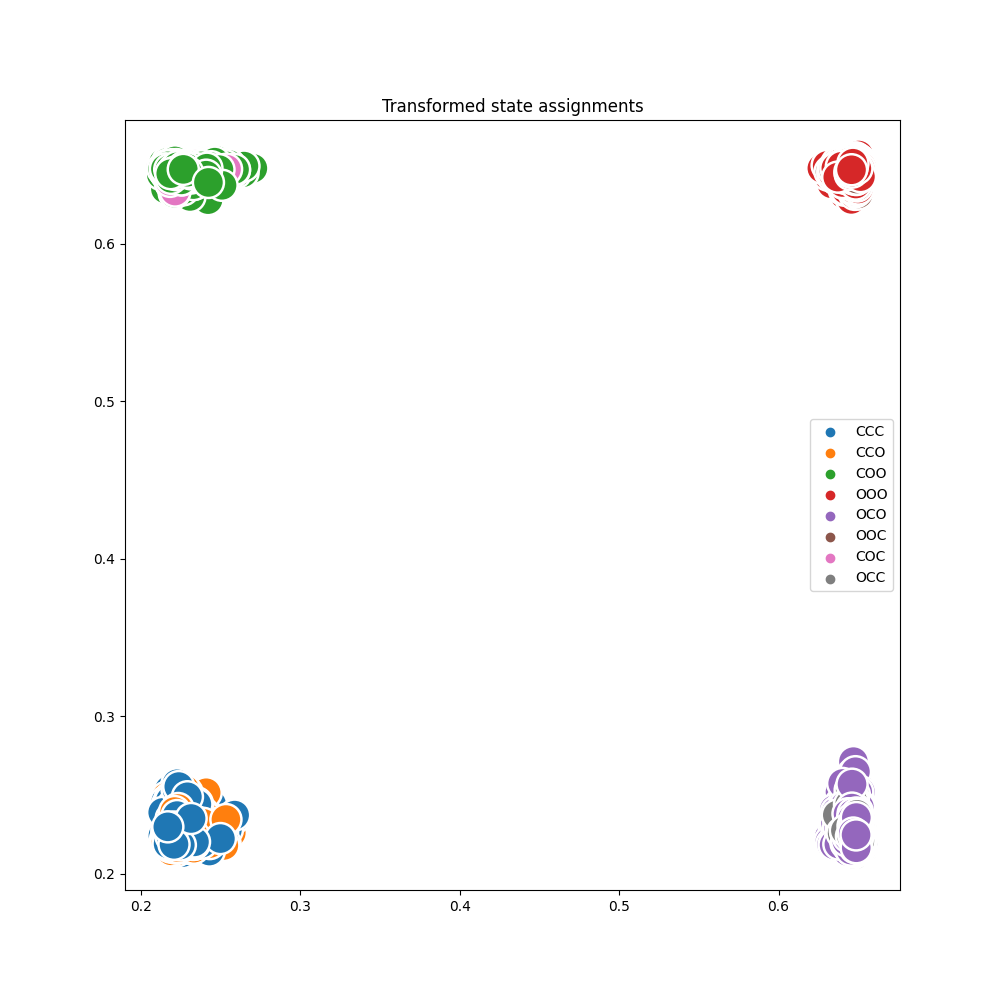

In [28]:
vampnet = vampnets[0]
projections = [vampnet.transform(traj) for traj in data]
projection_data_concat = np.concatenate(projections)

state_probabilities = projection_data_concat

assignments = state_probabilities.reshape(glic_trimer.trajectory.shape[0],3,2).argmax(2)

from sklearn.decomposition import PCA

#pca = PCA(n_components=2)
#transformed_space = pca.fit_transform(projection_data_concat)

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.scatterplot(projections[0].T[0],
            projections[0].T[2],
            hue=glic_trimer.trajectory_states,
#            hue=[str(stat) for stat in assignments],
            s=500,
            alpha=1,
            ax=ax)
plt.title('Transformed state assignments')
plt.show()

In [32]:
from deeptime.decomposition import VAMP

model = vampnets[0].fetch_model()

vamp_estimator = VAMP(lagtime=1, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()
print(f"VAMP-2 score under lag 1: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 1: s = 3.32


In [33]:
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

lagtimes = np.arange(1, 10, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(data) for lag in tqdm(lagtimes)]

ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')

  0%|          | 0/9 [00:00<?, ?it/s]

Text(170.88490342881943, 0.5, 'timescale')

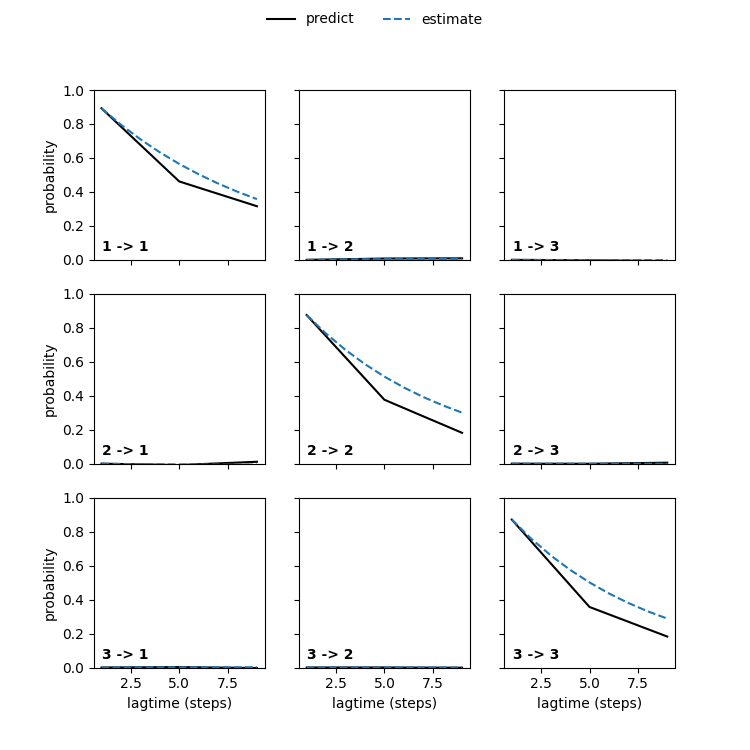

In [34]:
plot_ck_test(vamp_models[0].ck_test(vamp_models));

In [ ]:
vamp = vamp_models[0]
print(vamp.lagtime)

In [ ]:
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM

projections = [vamp.transform(traj) for traj in data]
cluster = KMeans(4, progress=tqdm).fit_fetch(projections)
dtrajs = [cluster.transform(x) for x in projections]

bmsms = [BayesianMSM(lagtime=lag).fit_fetch(dtrajs) for lag in tqdm(range(1, 6))]
ck_test = bmsms[0].ck_test(bmsms, 4)
plot_ck_test(ck_test);

In [ ]:
msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=1, dt_traj='1 step')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

In [ ]:
nstates = 4
cktest = msm.cktest(nstates, mlags=range(5))
pyemma.plots.plot_cktest(cktest, dt=1, units='step');

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[assignments],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

In [ ]:
metastable_traj = dtrajs

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [ ]:
metastable_traj = dtrajs
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.cluster_centers[msm.active_set[highest_membership]]

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *projection_data_concat[:, :2].T, metastable_traj[0], ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['CO','CC','OO','OC'],
    ax=ax)

ax.set_xlim(-1, 4)

fig.tight_layout()